# Predict on Exodus

Customers of Bank Beta is starting to leave. Their number is decreasing from month to month.

Management of the bank realizes that the cost is lower in retaining its existing customers than to attaining new customers.


In this project, a model will be built to predict if a customer is leaving the bank or not. 

A dataset is given on the historical behavior of the bank's clients, along with their contract termination.

The goal is to have highest F1 score possible, with its minimum on 0.59 with the testing dataset.

Other validation metric, AUC-ROC score, will also be measured, and then compared to the F1 score.

## Pre-processing, EDA, Feature Engineering

### Data observation

In [ ]:
# import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.utils import shuffle
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# save dataset in a variable and load its samples
df= pd.read_csv('/datasets/Churn.csv')
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
# load general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
# load statistical description
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
# Change the columns name to lowercase for simplicity
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

### Exploratory Data Analysis

<AxesSubplot:xlabel='exited', ylabel='count'>

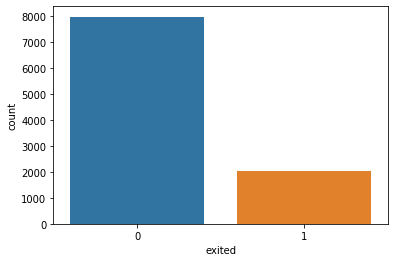

In [ ]:
# Univariate analysis target
sns.countplot(df['exited'])

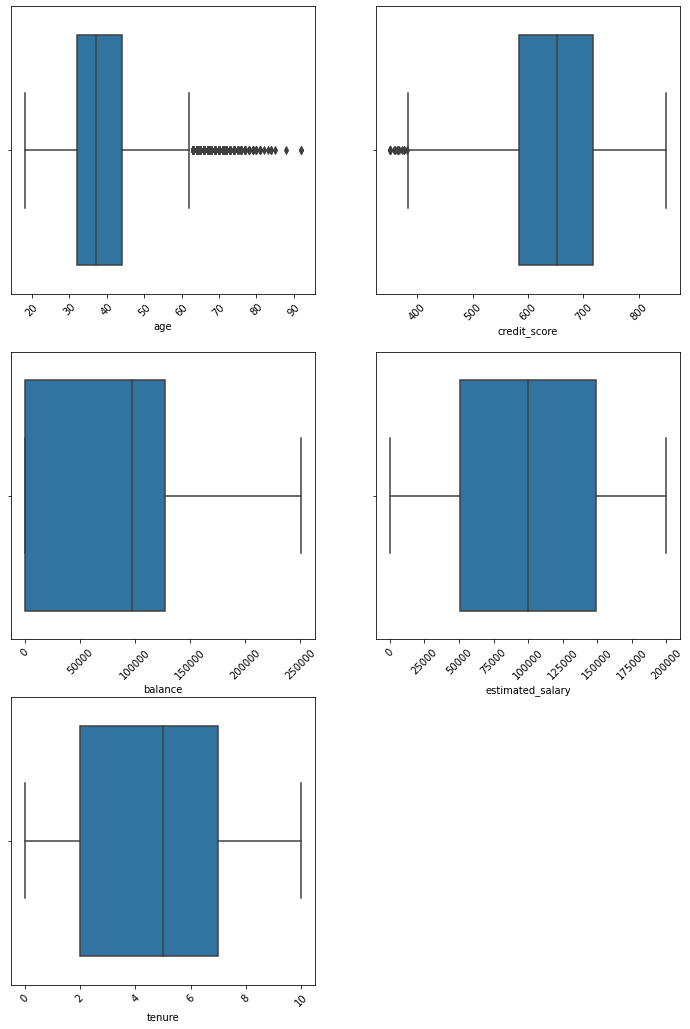

In [ ]:
# Univariate analysis relevant variables
numeric=['age', 'credit_score', 'balance','estimated_salary', 'tenure']
plt.subplots(figsize = (12, 18))
for i, var in enumerate(numeric):
    sns.boxplot(data=df, x=var, ax = plt.subplot(3, 2, i + 1))
    plt.xticks(rotation = 45)

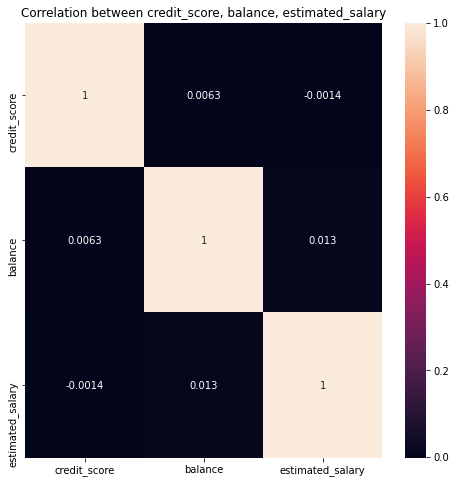

In [ ]:
# Check for any strong correlation in variables with potential to be correlated
related_variables = df[['credit_score', 'balance', 'estimated_salary']]

plt.figure(figsize=(8,8))
plt.title('Correlation between credit_score, balance, estimated_salary')
sns.heatmap(related_variables.corr(),annot=True)
plt.show()

From this early dataset observation it appears that:

1. There are missing values in Tenure of 909 observed data.

2. The target class is imbalance. Class 1 only makes around 20% of total observed data.

3. Some independent variables will be irrelevant to predicting model hence will need to be excluded from predictors:
    - row_number
    - customer_id
    - surname

4. Numeric variables need to be standard-scaled:
    - balance
    - estimated_salary
    
5. Writing of columns name are better in lowercase

6. There might be no significant outliers as the standard deviations in each variables are relatively low, and the figures of mean and median are not significantly vary. Although our boxplots suggest that there may be a small number of outliers in age and credit score. Hence both variables are to be standar-scaled as well.

7. There is unlikely correlation between variables. It is safe then to use all relevant variables as predictors.

In the next step, missing values in tenure will be checked if they are results of a random event or if there is actually any relation to other independent variables.

### Checking Missing Values

First, let us check the distribution of unique values in relevant variables. 

Next, after having the distribution of values in relevant variables, let us check if there the distributions differ significantly when filtered on the missing values.

In [ ]:
# check % distribution of values in tenure, especially the missing values
df.tenure.value_counts(dropna=False, normalize=True)*100

1.0     9.52
2.0     9.50
8.0     9.33
3.0     9.28
5.0     9.27
7.0     9.25
NaN     9.09
4.0     8.85
9.0     8.82
6.0     8.81
10.0    4.46
0.0     3.82
Name: tenure, dtype: float64

In [ ]:
# check % distribution of values in credit_score
(df.credit_score.value_counts(dropna=False, normalize=True)*100).head(10)

850    2.33
678    0.63
655    0.54
667    0.53
705    0.53
684    0.52
651    0.50
670    0.50
683    0.48
648    0.48
Name: credit_score, dtype: float64

In [ ]:
# check if there's a relation of missing values to credit_score
(df.query('tenure.isna()')['credit_score'].value_counts(normalize=True)*100).head(10)

850    2.530253
651    0.990099
630    0.990099
652    0.880088
706    0.880088
614    0.770077
670    0.770077
693    0.770077
710    0.770077
667    0.770077
Name: credit_score, dtype: float64

In [ ]:
# check % distribution of values in geography
df.geography.value_counts(dropna=False, normalize=True)*100

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [ ]:
# check if there's a relation of missing values to geography
df.query('tenure.isna()')['geography'].value_counts(normalize=True)*100

France     51.045105
Spain      25.192519
Germany    23.762376
Name: geography, dtype: float64

In [ ]:
# check % distribution of values in gender
df.gender.value_counts(dropna=False, normalize=True)*100

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [ ]:
# check if there's a relation of missing values to gender
df.query('tenure.isna()')['gender'].value_counts(normalize=True)*100

Male      53.135314
Female    46.864686
Name: gender, dtype: float64

In [ ]:
# check % distribution of values in age
(df.age.value_counts(dropna=False, normalize=True)*100).head(10)

37    4.78
38    4.77
35    4.74
36    4.56
34    4.47
33    4.42
40    4.32
39    4.23
32    4.18
31    4.04
Name: age, dtype: float64

In [ ]:
# check if there's a relation of missing values to num_of_products
(df.query('tenure.isna()')['age'].value_counts(normalize=True)*100).head(10)

36    6.050605
38    5.830583
40    5.390539
31    4.950495
32    4.840484
37    4.730473
35    4.730473
33    4.290429
39    3.960396
34    3.850385
Name: age, dtype: float64

In [ ]:
# check % distribution of values in balance
df.balance.value_counts(dropna=False, normalize=True)*100

0.00         36.17
105473.74     0.02
130170.82     0.02
72594.00      0.01
139723.90     0.01
             ...  
130306.49     0.01
92895.56      0.01
132005.77     0.01
166287.85     0.01
104001.38     0.01
Name: balance, Length: 6382, dtype: float64

In [ ]:
# check if there's a relation of missing values to balance
df.query('tenure.isna()')['balance'].value_counts(normalize=True)*100

0.00         36.743674
122924.75     0.110011
63227.00      0.110011
81553.93      0.110011
104469.58     0.110011
               ...    
132670.53     0.110011
108055.10     0.110011
126833.79     0.110011
157848.53     0.110011
118520.26     0.110011
Name: balance, Length: 576, dtype: float64

In [ ]:
# check % distribution of values in num_of_products
df.num_of_products.value_counts(dropna=False, normalize=True)*100

1    50.84
2    45.90
3     2.66
4     0.60
Name: num_of_products, dtype: float64

In [ ]:
# check if there's a relation of missing values to num_of_products
df.query('tenure.isna()')['num_of_products'].value_counts(normalize=True)*100

1    51.375138
2    44.664466
3     3.520352
4     0.440044
Name: num_of_products, dtype: float64

In [ ]:
# check % distribution of values in has_cr_card
df.has_cr_card.value_counts(dropna=False, normalize=True)*100

1    70.55
0    29.45
Name: has_cr_card, dtype: float64

In [ ]:
# check if there's a relation of missing values to has_cr_card
df.query('tenure.isna()')['has_cr_card'].value_counts(normalize=True)*100

1    71.067107
0    28.932893
Name: has_cr_card, dtype: float64

In [ ]:
# check % distribution of values in is_active_member
df.is_active_member.value_counts(dropna=False, normalize=True)*100

1    51.51
0    48.49
Name: is_active_member, dtype: float64

In [ ]:
# check if there's a relation of missing values to is_active_member
df.query('tenure.isna()')['is_active_member'].value_counts(normalize=True)*100

1    51.045105
0    48.954895
Name: is_active_member, dtype: float64

In [ ]:
# check % distribution of values of each class
df.exited.value_counts(dropna=False, normalize=True)*100

0    79.63
1    20.37
Name: exited, dtype: float64

In [ ]:
# check if there's a relation of missing values to exited
df.query('tenure.isna()')['exited'].value_counts(normalize=True)*100

0    79.867987
1    20.132013
Name: exited, dtype: float64

From checking the distributions of values in relevant variables, and the possibilities of their relations as well, it seems that the missing values in tenure are results of random events.

In the next step, a new dataset will be created with:

1. Missing values filled with its median value

2. One-hot-encoder for variables geography because it has 3 classes

3. Standard scale on variable balance and estimated_salary because their values can vary widely.

### Handling Missing Values

In [ ]:
# create new dataset with missing values filled
df_new = df.fillna(df.tenure.median())
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Label Encoding

In this step, the categorical variables will be labeled using numerical values so that that libraries can read them when building the model.

In [ ]:
# label encode variable gender
encoder = LabelEncoder()
df.gender = pd.DataFrame(encoder.fit_transform(df.gender))
df.gender.value_counts()

1    5457
0    4543
Name: gender, dtype: int64

In [ ]:
# label encode variable geography
df.geography = pd.DataFrame(encoder.fit_transform(df.geography))
df.geography.value_counts()

0    5014
1    2509
2    2477
Name: geography, dtype: int64

### One-hot encode categorical variables

In [ ]:
# apply one-hot-encoder to geography
df_new = pd.get_dummies(df_new, columns=['geography'])
df_new.head()

,row_number,customer_id,surname,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,geography_Spain
0,1,15634602,Hargrave,619,Female,42,2.0,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,Female,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,Female,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,Female,39,1.0,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,Female,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


In [ ]:
# label encode the gender class
df_new.gender = pd.DataFrame(encoder.fit_transform(df_new.gender))
df_new.gender.value_counts()

1    5457
0    4543
Name: gender, dtype: int64

### Standars-scale numeric variables

In [ ]:
# standar scale numeric variables: balance and estimated_salary

scaler = StandardScaler()
scaler.fit(df_new[numeric])
df_new[numeric] = scaler.transform(df_new[numeric])
df_new.head()

,row_number,customer_id,surname,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,geography_Spain
0,1,15634602,Hargrave,-0.326221,0,0.293517,-1.086246,-1.225848,1,1,1,0.021886,1,1,0,0
1,2,15647311,Hill,-0.440036,0,0.198164,-1.448581,0.117350,1,0,1,0.216534,0,0,0,1
2,3,15619304,Onio,-1.536794,0,0.293517,1.087768,1.333053,3,1,0,0.240687,1,1,0,0
3,4,15701354,Boni,0.501521,0,0.007457,-1.448581,-1.225848,2,0,0,-0.108918,0,1,0,0
4,5,15737888,Mitchell,2.063884,0,0.388871,-1.086246,0.785728,1,1,1,-0.365276,0,0,0,1


### Interim Conclusion

The missing values are already filled. One-hot-encoder is already applied to geography. Standard-scaler is already applied to age, credit_scoring, balance, and estimated_salary. 

As the target class is unbalanced, then metric accuracy will not be used to validate the model. F1 and AUC-ROC scores will be used instead. 

The modified dataset is saved to a new variable, as both the old and the new will be used to make models with different algorithms.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1</b> <a class="tocSkip"></a>

Secara umum pemrosesan data sudah bagus.
</div>

## Train-test split dataset

Now, we have 2 datasets. One is the dataset that is not modified, except for its columns' naming. The other one is the dataset that has been feature-engineered with OHE, standard scaler, as well as having its missing values filled.

In the next step, both datasets will be split into three: train (75%), valid (15%), test (10%).

The purpose of maintaining both datasets is to compare how different algorithms in building models with and without missing values, and without and with feature engineering result.

Train test split will be stratified as the target class is imbalanced.

In [ ]:
# select only relevant variables for features
drop_cols = ['row_number', 'customer_id', 'surname', 'exited']
df_x = df.drop(drop_cols, axis=1)
df_x.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,619,0,0,42,2.0,0.00,1,1,1,101348.88
1,608,2,0,41,1.0,83807.86,1,0,1,112542.58
2,502,0,0,42,8.0,159660.80,3,1,0,113931.57
3,699,0,0,39,1.0,0.00,2,0,0,93826.63
4,850,2,0,43,2.0,125510.82,1,1,1,79084.10


In [ ]:
# select only relevant variables for features
drop_cols = ['row_number', 'customer_id', 'surname', 'exited']
df_new_x = df_new.drop(drop_cols, axis=1)
df_new_x.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
0,-0.326221,0,0.293517,-1.086246,-1.225848,1,1,1,0.021886,1,0,0
1,-0.440036,0,0.198164,-1.448581,0.117350,1,0,1,0.216534,0,0,1
2,-1.536794,0,0.293517,1.087768,1.333053,3,1,0,0.240687,1,0,0
3,0.501521,0,0.007457,-1.448581,-1.225848,2,0,0,-0.108918,1,0,0
4,2.063884,0,0.388871,-1.086246,0.785728,1,1,1,-0.365276,0,0,1


In [ ]:
# select variable exit as target
df_y = df['exited']
df_y.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [ ]:
# select variable exit as target
df_new_y = df['exited']
df_new_y.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [ ]:
# train-test split with test size of 25%
x_train, x_val_test, y_train, y_val_test = train_test_split(df_x, df_y, stratify=df_y, test_size = 0.25, random_state=123)
x_valid, x_test, y_valid, y_test = train_test_split(x_val_test, y_val_test, stratify=y_val_test, test_size = 0.4, random_state=123)
x_valid.shape


(1500, 10)

In [ ]:
# train-test split with test size of 25%
new_x_train, new_x_val_test, new_y_train, new_y_val_test = train_test_split(df_new_x, df_new_y, stratify=df_new_y, test_size = 0.25, random_state=123)
new_x_valid, new_x_test, new_y_valid, new_y_test = train_test_split(new_x_val_test, new_y_val_test, stratify=new_y_val_test, test_size = 0.4, random_state=123)
new_x_valid.shape


(1500, 12)

Both datasets are split already, each to train, valid, and test. The old dataset has 10 columns, while the new 12.

## LightGBM Classifier

With the first dataset that contains missing values, categorical variables left as they are, and no standar scaling applied to the numerical values, a model will be built using LightGBM Classifier.

With the first dataset, there are 10 independent variables. We will see if setting L1 will do any good to the model.

The dataset consists of 1,000 observed data. This is not a numerous amount, but we will see if setting L2 do any good to the model.

In [ ]:
# train model and look for optimal n_estimators hyperparameter
best_score = 0
best_est = 0
for leave in range(20, 71, 10):
    lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=leave, max_depth=6, 
                          n_estimators=100, is_unbalance=True, min_child_samples = 100,
                         random_state=123)
    lgbm.fit(x_train, y_train)
    predict_valid = lgbm.predict(x_valid)
    f1_valid = f1_score(y_valid, predict_valid)
    print("num_leaves =", leave, ": ", end='')
    print(f1_valid)

num_leaves = 20 : 0.6111869031377899
num_leaves = 30 : 0.6039325842696629
num_leaves = 40 : 0.6013986013986014
num_leaves = 50 : 0.6141078838174274
num_leaves = 60 : 0.6141078838174274
num_leaves = 70 : 0.6141078838174274


From training the model with different hyperparameter num_leaves, it seems that num_leaves of 20 gives a good result already. Using the valid dataset, F1 score is 0.61. Hence this num_leaves will be set at 20, and applied when training dataset.

In [ ]:
# set hyperparameter num_leave at 20, and find F1 and AUC-ROC score using the train dataset
lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=20, max_depth=6, 
                      n_estimators=100, is_unbalance=True, min_child_samples = 100,
                      random_state=123)
lgbm.fit(x_train, y_train)
predict_train = lgbm.predict(x_train)
f1_train = f1_score(y_train, predict_train)
f1_train

prob_train = lgbm.predict_proba(x_train)
prob_one_train = prob_train[:, 1]

auc_roc_train = roc_auc_score(y_train, prob_one_train)

print("F1:", f1_train,", ", end='')
print( "AUC-ROC: ", auc_roc_train)

F1: 0.6784769962982549 , AUC-ROC:  0.9219692443444627


F1: 0.6111869031377899 , AUC-ROC:  0.8697029974621031


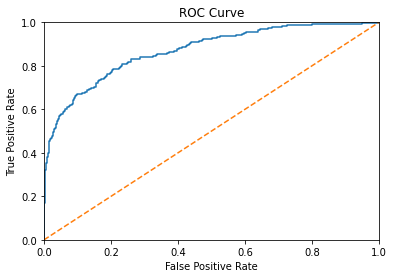

In [ ]:
# testing the model with the valid dataset, find F1 and AUC-ROC score, and make ROC curve using the valid dataset
predict_valid = lgbm.predict(x_valid)
f1_valid = f1_score(y_valid, predict_valid)
f1_valid

prob_valid = lgbm.predict_proba(x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(y_valid, prob_one_valid)

print("F1:", f1_valid,", ", end='')
print( "AUC-ROC: ", auc_roc_valid)

fpr, tpr, thresholds = roc_curve(y_valid, prob_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# testing the model with the test dataset, find F1 and AUC-ROC score using the test dataset
predict_test = lgbm.predict(x_test)
f1_test = f1_score(y_test, predict_test)
f1_test

prob_test = lgbm.predict_proba(x_test)
prob_one_test = prob_test[:, 1]

auc_roc_test = roc_auc_score(y_test, prob_one_test)

print("F1:", f1_test,", ", end='')
print( "AUC-ROC: ", auc_roc_test)

F1: 0.596958174904943 , AUC-ROC:  0.8590132032712583


### Interim Conclusion

With algorithm LGBMClassifier, we manage to find a model with **F1 score above 0.59 and AUC-ROC score above 0.85**.

The model is quite stable when reviewed using those 2 metrics as there is not much difference on the scores, regardless the datasets used to predict.

Hence this LGBM model already meets the expectation on the minumin F1 score, and not being overfit.

## Random Forest

We have succesfully built one model that meets the required criteria using LGBMClassifier. 

In LGBMClassifier, the imbalanced state of the target class is handled by the algorithm by tuning the related hyperparameter.

In this next step, Random Forest will be used to build a model, with imbalanced data handled by upsampling the minority class. 

A comparison will be done by using downsampling method the majority class.

For this, the second, new dataset will be needed (missing values filled, OHE applied, Standard Scaler applied).

### Upsampling

In [ ]:
# upsample the observed data of target class 1
def upsample(x, y, repeat):
    x_zeros = x[y ==0]
    x_ones = x[y ==1]
    y_zeros = y [y==0]
    y_ones = y [y==1]
    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    x_upsampled, y_upsampled = shuffle(x_upsampled, y_upsampled, random_state=123)
    return x_upsampled, y_upsampled

x_upsampled, y_upsampled = upsample(new_x_train, new_y_train, 3)


print(x_upsampled[y_upsampled == 0].shape)
print(x_upsampled[y_upsampled == 1].shape)

(5972, 12)
(4584, 12)


In [ ]:
# train model and look for optimal n_estimators hyperparameter
for est in range(40, 101, 10):
    rfc = RandomForestClassifier(random_state=123, n_estimators=est, 
                                 max_depth=4)
    rfc.fit(x_upsampled, y_upsampled)
    predict_valid = rfc.predict(new_x_valid)
    f1_valid = f1_score(new_y_valid, predict_valid)
    print("n_estimators =", est, ": ", end='')
    print(f1_valid)
    

n_estimators = 40 : 0.6265432098765432
n_estimators = 50 : 0.6125574272588056
n_estimators = 60 : 0.6085626911314985
n_estimators = 70 : 0.6109422492401215
n_estimators = 80 : 0.6144578313253012
n_estimators = 90 : 0.6172465960665658
n_estimators = 100 : 0.6146926536731635


The minority target class is upsampled for 3 times.

Building the random forest with upsampled train dataset results in f1 score of above 0.60. With n_estimators set at 40, the model performs well already.

In the next step, a comparison will be done to show how the performance differs when training is done using the imbalanced train dataset.

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1195
           1       0.59      0.67      0.63       305

    accuracy                           0.84      1500
   macro avg       0.75      0.77      0.76      1500
weighted avg       0.85      0.84      0.84      1500

AUC-ROC:  0.855544276013444


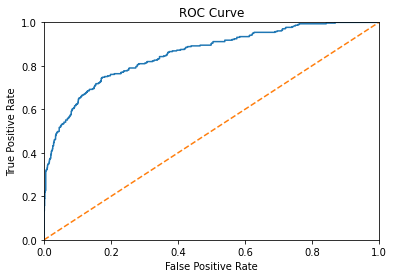

In [ ]:
# build best model, with n_estimators set at 40, using upsampled train dataset

rfc_v1 = RandomForestClassifier(random_state=123, n_estimators=40, 
                                max_depth=4)
rfc_v1.fit(x_upsampled, y_upsampled)

predict_valid = rfc_v1.predict(new_x_valid)

prob_valid = rfc_v1.predict_proba(new_x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(new_y_valid, prob_one_valid)

print(classification_report(new_y_valid, predict_valid))
print( "AUC-ROC: ", auc_roc_valid)

fpr, tpr, thresholds = roc_curve(new_y_valid, prob_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1195
           1       0.96      0.24      0.39       305

    accuracy                           0.84      1500
   macro avg       0.90      0.62      0.65      1500
weighted avg       0.86      0.84      0.80      1500

AUC-ROC:  0.853599012277934


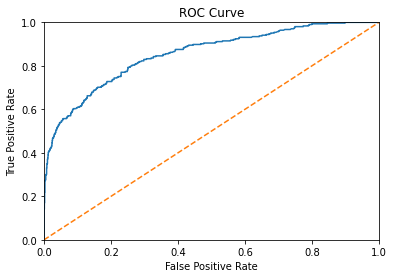

In [ ]:
# build best model, with n_estimators set at 40, with imbalanced train dataset

rfc_v2 = RandomForestClassifier(random_state=123, n_estimators=40, 
                                max_depth=4)
rfc_v2.fit(new_x_train, new_y_train)

predict_valid = rfc_v2.predict(new_x_valid)

prob_valid = rfc_v2.predict_proba(new_x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(new_y_valid, prob_one_valid)


print(classification_report(new_y_valid, predict_valid))
print( "AUC-ROC: ", auc_roc_valid)

fpr, tpr, thresholds = roc_curve(new_y_valid, prob_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

It appears that training the randomforest model with imbalanced dataset results in very low performance model when measure using F1 score metric. 

All hyperparameters set at the same values, the F1 score is only 0.39. 

This is significantly lower than the F1 score of the upsampled dataset, that is 0.62.

However one interesting fact is the AUC-ROC score for both the imbalanced and and upsampled dataset are well enough, above 0.85.

In [ ]:
# using training dataset to get F1 score and AUC-ROC score

predict_train = rfc_v1.predict(new_x_train)

prob_train = rfc_v1.predict_proba(new_x_train)
prob_one_train = prob_train[:, 1]

auc_roc_train = roc_auc_score(new_y_train, prob_one_train)


print(classification_report(new_y_train, predict_train))
print( "AUC-ROC: ", auc_roc_train)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5972
           1       0.59      0.63      0.61      1528

    accuracy                           0.83      7500
   macro avg       0.75      0.76      0.75      7500
weighted avg       0.84      0.83      0.84      7500

AUC-ROC:  0.8538446651564193


In [ ]:
# using test dataset to get F1 score and AUC-ROC score

predict_test = rfc_v1.predict(new_x_test)

prob_test = rfc_v1.predict_proba(new_x_test)
prob_one_test = prob_test[:, 1]

auc_roc_test = roc_auc_score(new_y_test, prob_one_test)


print(classification_report(new_y_test, predict_test))
print( "AUC-ROC: ", auc_roc_test)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       796
           1       0.53      0.62      0.57       204

    accuracy                           0.81      1000
   macro avg       0.72      0.74      0.73      1000
weighted avg       0.82      0.81      0.82      1000

AUC-ROC:  0.8371822347029263


### Interim Conclusion

With upsampling method, the random forest model performs significantly better. F1 score of 0.39 can increase to 0.62.

There is no issue of overfitting.

However the random forest model built here does not manage to meet the expectation of having F1 score (with the test dataset) of above 0.59. The upsampled trained model can only **score 0.57 on F1**. 

Although **the AUC-ROC is as high as 0.83**, the bank needs a model that can perform as good as one that has F1 score of 0.59 or more.



### Downsampling

In this next step, downsample method will applied to the observed data of minority class in the train dataset to build a random forest model.

In [ ]:
# downsample the observed data of target class 0

def downsample(x, y, fraction):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    x_downsampled = pd.concat([x_zeros.sample(frac=fraction, random_state=123)] + [x_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=123)] + [y_ones])
    x_downsampled, y_downsampled = shuffle(x_downsampled, y_downsampled, random_state=123)
    return x_downsampled, y_downsampled


x_downsampled, y_downsampled = downsample(new_x_train, new_y_train, 0.3)

print(x_downsampled[y_downsampled == 0].shape)
print(x_downsampled[y_downsampled == 1].shape)

(1792, 12)
(1528, 12)


In [ ]:
# train model and look for optimal n_estimators hyperparameter
for est in range(40, 101, 10):
    rfc = RandomForestClassifier(random_state=123, n_estimators=est, 
                                 max_depth=4)
    rfc.fit(x_downsampled, y_downsampled)
    predict_valid = rfc.predict(new_x_valid)
    f1_valid = f1_score(new_y_valid, predict_valid)
    print("n_estimators =", est, ": ", end='')
    print(f1_valid)
    

n_estimators = 40 : 0.6054794520547946
n_estimators = 50 : 0.612859097127223
n_estimators = 60 : 0.610729023383769
n_estimators = 70 : 0.6085753803596128
n_estimators = 80 : 0.6052269601100413
n_estimators = 90 : 0.6038251366120219
n_estimators = 100 : 0.6010928961748634


The majority target class is downsampled to 0.3 fraction.

Building the random forest with downsampled train dataset results in f1 score of above 0.60. With n_estimators set at 40, the model performs well already. Hence the n_estimators will be set at 40 the same like previous model using upsampling method, to check on performance comparison.

In the next step, a comparison will be done to show how the performance differs when training is done using the imbalanced train dataset.

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1195
           1       0.52      0.72      0.61       305

    accuracy                           0.81      1500
   macro avg       0.72      0.78      0.74      1500
weighted avg       0.84      0.81      0.82      1500

AUC-ROC:  0.857687084162151


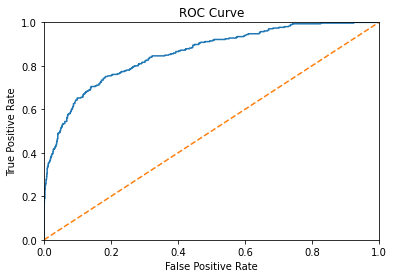

In [ ]:
# build best model, with n_estimators set at 40, using downsampled train dataset

rfc_v3 = RandomForestClassifier(random_state=123, n_estimators=40, 
                                max_depth=4)
rfc_v3.fit(x_downsampled, y_downsampled)

predict_valid = rfc_v3.predict(new_x_valid)

prob_valid = rfc_v3.predict_proba(new_x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(new_y_valid, prob_one_valid)

print(classification_report(new_y_valid, predict_valid))
print( "AUC-ROC: ", auc_roc_valid)

fpr, tpr, thresholds = roc_curve(new_y_valid, prob_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1195
           1       0.96      0.24      0.39       305

    accuracy                           0.84      1500
   macro avg       0.90      0.62      0.65      1500
weighted avg       0.86      0.84      0.80      1500

AUC-ROC:  0.853599012277934


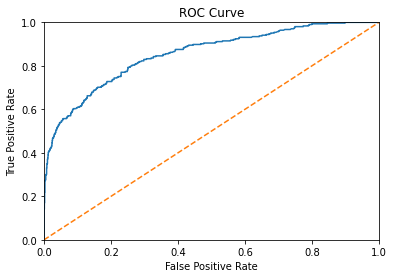

In [ ]:
# build best model, with n_estimators set at 40, with imbalanced train dataset

rfc_v4 = RandomForestClassifier(random_state=123, n_estimators=40, 
                                max_depth=4)
rfc_v4.fit(new_x_train, new_y_train)

predict_valid = rfc_v4.predict(new_x_valid)

prob_valid = rfc_v4.predict_proba(new_x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(new_y_valid, prob_one_valid)

print(classification_report(new_y_valid, predict_valid))
print( "AUC-ROC: ", auc_roc_valid)

fpr, tpr, thresholds = roc_curve(new_y_valid, prob_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

It appears that training the randomforest model with imbalanced dataset results in very low performance model when measure using F1 score metric. 

It leads in the same conclusion when applying upsample method to the minority class.

All hyperparameters set at the same values, the F1 score is only 0.39. 

This is significantly lower than the F1 score of the upsampled dataset, that is 0.61.

However one interesting fact is the AUC-ROC score for both the imbalanced and and upsampled dataset are well enough, above 0.85.

In [ ]:
# using training dataset to get F1 score and AUC-ROC score

predict_train = rfc_v3.predict(new_x_train)

prob_train = rfc_v3.predict_proba(new_x_train)
prob_one_train = prob_train[:, 1]

auc_roc_train = roc_auc_score(new_y_train, prob_one_train)


print(classification_report(new_y_train, predict_train))
print( "AUC-ROC: ", auc_roc_train)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      5972
           1       0.51      0.71      0.59      1528

    accuracy                           0.80      7500
   macro avg       0.72      0.77      0.73      7500
weighted avg       0.83      0.80      0.81      7500

AUC-ROC:  0.8525945029684777


In [ ]:
# using test dataset to get F1 score and AUC-ROC score

predict_test = rfc_v3.predict(new_x_test)

prob_test = rfc_v3.predict_proba(new_x_test)
prob_one_test = prob_test[:, 1]

auc_roc_test = roc_auc_score(new_y_test, prob_one_test)


print(classification_report(new_y_test, predict_test))
print( "AUC-ROC: ", auc_roc_test)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       796
           1       0.48      0.69      0.57       204

    accuracy                           0.78      1000
   macro avg       0.69      0.75      0.71      1000
weighted avg       0.82      0.78      0.80      1000

AUC-ROC:  0.8343063355995666


### Interim Conclusion

With downsampling method, the random forest model performs significantly better. F1 score of 0.39 can increase to 0.61.

There is no issue of overfitting.

However the random forest model built here does not manage to meet the expectation of having F1 score (with the test dataset) of above 0.59. The downsampled trained model can only **score 0.57 on F1**.

Although **the AUC-ROC is as high as 0.83**, the bank needs a model that can perform as good as one that has F1 score of 0.59 or more.

It can be concluded that both model with upsample and downsample method increase performance of a model for an imbalanced dataset.

In the next step, a regression algorithm will be used to build the next model.

## Logistic Regression

In [ ]:

#List Hyperparameters to test
penalty = ['l1', 'l2', None]
C = np.logspace(-2,2,10)
solver= ['liblinear', 'newton-cholesky']
hyperparameters = dict(penalty=penalty, C=C, solver=solver)

#create model with grid search
logreg = LogisticRegression(random_state=123, class_weight='balanced')
clf = GridSearchCV(logreg, hyperparameters, cv=10)

# train model
logreg = clf.fit(new_x_train, new_y_train)
print('Best Penalty:', logreg.best_estimator_.get_params()['penalty'])
print('Best C:', logreg.best_estimator_.get_params()['C'])
print('Best Solver:', logreg.best_estimator_.get_params()['solver'])

# validate model
predict_valid = logreg.predict(new_x_valid)
f1_valid = f1_score(new_y_valid, predict_valid)
f1_valid

Best Penalty: l1
Best C: 0.01
Best Solver: liblinear


0.49275362318840576

In [ ]:
# Build final model with penalty set as 'l1' and C at 0.01, and solver liblinear
logreg_final = LogisticRegression(random_state=123, class_weight='balanced', solver='liblinear', penalty='l1', C= 0.01)
logreg_final.fit(new_x_train, new_y_train)
predict_valid = logreg_final.predict(new_x_valid)
f1_valid = f1_score(new_y_valid, predict_valid)
f1_valid

prob_valid = logreg_final.predict_proba(new_x_valid)
prob_one_valid = prob_valid[:, 1]

auc_roc_valid = roc_auc_score(new_y_valid, prob_one_valid)

print("F1:", f1_valid,", ", end='')
print( "AUC-ROC: ", auc_roc_valid)

F1: 0.49275362318840576 , AUC-ROC:  0.7715865285684889


In [ ]:
# F1 score of the model with the train dataset
predict_train = logreg_final.predict(new_x_train)
f1_train = f1_score(new_y_train, predict_train)
f1_train

prob_train = logreg_final.predict_proba(new_x_train)
prob_one_train = prob_train[:, 1]

auc_roc_train = roc_auc_score(new_y_train, prob_one_train)

print("F1:", f1_train,", ", end='')
print( "AUC-ROC: ", auc_roc_train)

F1: 0.5128331688055281 , AUC-ROC:  0.7744171206467879


In [ ]:
# F1 score of the model with the test dataset
predict_test = logreg_final.predict(new_x_test)
f1_test = f1_score(new_y_test, predict_test)
f1_test

prob_test = logreg_final.predict_proba(new_x_test)
prob_one_test = prob_test[:, 1]

auc_roc_test = roc_auc_score(new_y_test, prob_one_test)

print("F1:", f1_test,", ", end='')
print( "AUC-ROC: ", auc_roc_test)

F1: 0.46554934823091243 , AUC-ROC:  0.736568873780668


With logistic regression, best combination of hyperparameters resulted from cross validation gridsearch:
- solver: liblinear
- c: 0.01
- penalty: l1
And class_weight set as balanced due to the imbalance dataset, the F1 score is 0.46 and AUC-ROC is 0.73.

This model does not meet the required F1 score of 0.59.

## Final Conclusions

The project of building machine learning for Bank Beta is started by observing data, some exploratory data analysis, and continued by feature engineering.

Missing values are handled, OHE is applied, and standard scaler is applied.

There are three algorithm tested: LightGBM, RandomForest, and LogisticRegression.

In building with LightGBM, missing values are handled by the machine, and imbalance dataset is left as is.

The F1 score is 0.59 and AUC-ROC score is 0.85. That means this model meets the required minimum F1 score Bank Beta.

Next, another models are built with alogirthm Random Forest. One is applied with Upsampling method. And the other, downsampling method.

It shows that both upsampling method and downsampling method when training the models increase their performance significantly, as measured by their F1 score.

However as the final test of the models show F1 score of 0.57, the models do not meet the required minimum F1 score Bank Beta.

Lastly, another model is built using regression algorithm, that is LogisticRegression.

Hyperparameters class_weigh set as balanced due to the imbalance dataset, and as a result from gridsearch CV, solver is set as liblinear, c at 0.01, and penalty as l1.

Final testing of the model shows that it has F1 score of 0.46 and AUC-ROC of 0.73. This also does not meet the required minimum F1 score Bank Beta. 

Conclusion to this project is to use the model with algorithm LightGBM.

Most interesting findings in building a model for this projects are:

1. Both method of Upsampling and Downsampling does increase a performance of the model trained, especially when the observed data have imbalance target class.

2. Two models might have similarly high AUC-ROC Score although one's F1 Score of positive class might be way more superior than the other's. Hence when the purpose is to build a model that is able to capture as many Positive class as possible, AUC-ROC score alone is not sufficient to be metric of its performance. F1 score is important.

3. In the case of an imbalanced dataset, accuracy is not a metric to be referred to when measuring the model's performance, as it is easy to achieve high accuracy score just by make prediction by the majority class. F1 Score that relies on both precision and recall will be a lot better compass showing the how robust the model is. Further, when predicting one class is the most important end of building a model, F2 or more can be used, to put emphasize on Recall.